## Секция python. Генератор чисел Фибоначчи

In [1]:
from typing import Iterator


def fibonacci_generator(n: int) -> Iterator[int] | None:
    """Return an object that produces n first numbers of Fibonacci sequence

    Args:
        n (int): amount of numbers

    Raises:
        TypeError: n must be 'int'
        ValueError: n < 0, must be >= 0

    Returns:
        Iterator[int] or None

    """
    # Отработка некорректных случаев использования и нулевого значения
    if not isinstance(n, int):
        raise TypeError(f"n must be 'int' not '{n.__class__.__name__}'")
    elif n < 0:
        raise ValueError("n < 0, must be >= 0")
    elif n == 0:
        return None

    current_number = 0  # текущий член последовательности
    tmp_number = 0  # предыдущий член последовательности
    count = 0  # счетчик

    while count < n:
        yield current_number

        # Для генерации первых двух членов последовательности (0 и 1)
        if current_number < 1:
            current_number += 1

        # Для остальных членов полседовательности
        else:
            buffer = tmp_number
            tmp_number = current_number
            current_number += buffer
        count += 1

In [2]:
# Примеры использования

for n in ["a", -1, 0, 10]:
    print(f"input: n = {n} ==> output:", end=" ")
    try:
        for num in fibonacci_generator(n):
            print(num, end=" ")
    except TypeError:
        print(f"n must be 'int' not '{n.__class__.__name__}'")
    except ValueError:
        print("n < 0, must be >= 0")

input: n = a ==> output: n must be 'int' not 'str'
input: n = -1 ==> output: n < 0, must be >= 0
input: n = 0 ==> output: input: n = 10 ==> output: 0 1 1 2 3 5 8 13 21 34 

## Секция SQL

### 1. Вывести отдел с наибольшим числом сотрудников

In [ ]:
-- Вариант запроса с использованием внутреннего соединения. Если требуется количество сотрудников

SELECT d.id, d.name, count(*) AS amount_of_personal
FROM department AS d
JOIN personal AS p ON d.id = p.id_dep
GROUP BY d.id, d.name
ORDER BY amount_of_personal DESC
LIMIT 1

In [ ]:
-- Вариант запроса с использованием подзапроса. Если не требуется количество сотрудников

SELECT id, name
FROM department
WHERE id = (
	SELECT id_dep
	FROM personal 
	GROUP BY id_dep
	ORDER BY count(*) DESC
	LIMIT 1
)

### 2. Вывести список сотрудников, получающих заработную плату выше, чем у руководителя

In [ ]:
-- Запрос удобно реализовать с использованием внутреннего соединения, поставив в соответствие каждому работнику его руководителя
-- Затем отбираются те строки, в которых зарплата сотрудника выше, чем у руководителя

SELECT p1.id_pers, p1.name
FROM personal AS p1
JOIN personal AS p2 ON p1.id_head = p2.id_pers
WHERE p1.sal > p2.sal

## Секция ML. Определение ОКВЭД фирмы

### 1. Обзор данных

In [3]:
# Импорт необходимых библиотек, классов и функций

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import iqr

In [4]:
# Загрузка данных в DataFrame

inn_info_public_df = pd.read_csv("TestCase-Industry/inn_info_public.csv")
pays_df = pd.read_csv("TestCase-Industry/pays.csv")

In [5]:
inn_info_public_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hash_inn   240069 non-null  int64
 1   okved2     240069 non-null  int64
 2   region     240069 non-null  int64
 3   is_public  240069 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [6]:
pays_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hash_inn_kt  5430150 non-null  int64  
 1   hash_inn_dt  5430150 non-null  int64  
 2   week         5430150 non-null  int64  
 3   count        5430150 non-null  int64  
 4   sum          5429025 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [7]:
inn_info_public_df.describe()

,hash_inn,okved2,region
count,240069.000000,240069.000000,240069.000000
mean,130236.418734,18.771803,58.938343
std,75201.512046,22.078592,26.935958
min,0.000000,-1.000000,0.000000
25%,65170.000000,-1.000000,37.000000
50%,130169.000000,12.000000,60.000000
75%,195380.000000,34.000000,84.000000
max,260515.000000,79.000000,90.000000


In [8]:
pays_df.describe()

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5.430150e+06,5.430150e+06,5.430150e+06,5.430150e+06,5.429025e+06
mean,1.288775e+05,1.305203e+05,1.161926e+01,2.919462e+00,3.939404e+02
std,7.569651e+04,7.564641e+04,6.332949e+00,5.050308e+00,7.259421e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e-01
25%,6.292900e+04,6.476100e+04,6.000000e+00,1.000000e+00,3.280000e+00
50%,1.273810e+05,1.295880e+05,1.200000e+01,2.000000e+00,1.456800e+01
75%,1.943850e+05,1.966060e+05,1.700000e+01,3.000000e+00,6.920000e+01
max,2.605110e+05,2.605150e+05,2.300000e+01,2.530000e+03,3.966400e+06


In [9]:
# Удаление пропусков в pays_df
pays_df = pays_df.dropna()

# В данном случае сумма платежей считается по абсолютным знаечниям, следовательно не может быть отрицательной

pays_df = pays_df.loc[pays_df["sum"] >= 0]

In [10]:
inn_info_public_df

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True
...,...,...,...,...
240064,139170,4,12,True
240065,13553,12,12,True
240066,230402,12,12,True
240067,170104,63,12,True


In [11]:
pays_df

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6
...,...,...,...,...,...
5430145,260511,77935,5,2,399.6
5430146,260511,77935,12,2,439.6
5430147,260511,77935,14,2,7.6
5430148,260511,77935,15,2,79.6


In [12]:
# Количество классов (уникальных кодов ОКВЭД)
inn_info_public_df["okved2"].unique().__len__() - 1

80

In [13]:
# Количество фирм, подлежащих классификации
inn_info_public_df.loc[inn_info_public_df["okved2"] == -1].__len__()

78654

In [14]:
# Количество фирм, подлежащих классификации, с информацией об отправленных платежах
(
    set(pays_df["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] == -1])
).__len__()

49556

In [15]:
# Количество фирм, подлежащих классификации, с информацией о принятых платежах
(
    set(pays_df["hash_inn_dt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] == -1])
).__len__()

61422

In [16]:
# Количество фирм, подлежащих классификации, одновременно с информацией об отправленных и о полученных платежах
(
    set(pays_df["hash_inn_dt"])
    & set(pays_df["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] == -1])
).__len__()

32885

In [17]:
# Количество фирм, не подлежащих классификации
inn_info_public_df.loc[inn_info_public_df["okved2"] != -1].__len__()

161415

In [18]:
# Стратификация фирм по классам
inn_info_public_df.loc[inn_info_public_df["okved2"] != -1]["okved2"].value_counts()

okved2
12    44918
34    13654
14    10179
4      7617
52     6986
      ...  
2        90
36       84
13       68
73       64
1        50
Name: count, Length: 80, dtype: int64

In [19]:
# Количество фирм, не подлежащих классификации, с информацией об отправленных платежах
(
    set(pays_df["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] != -1])
).__len__()

101376

In [20]:
# Количество фирм,не подлежащих классификации, с информацией о принятых платежах
(
    set(pays_df["hash_inn_dt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] != -1])
).__len__()

126184

In [21]:
# Количество фирм, не подлежащих классификации, одновременно с информацией об отправленных и о полученных платежах
set_inn_with_in_out_pays = (
    set(pays_df["hash_inn_dt"])
    & set(pays_df["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] != -1])
)
len(set_inn_with_in_out_pays)

67422

In [22]:
# Количестов фирм, имеющих информацию о внутренних платежах
pays_df.loc[pays_df["hash_inn_dt"] == pays_df["hash_inn_kt"]][
    "hash_inn_kt"
].unique().__len__()

17199

In [23]:
# Количество классов (уникальных кодов ОКВЭД) среди фирм, не подлежащих классификации и имеющих информацию о входящих и исходящих платежах
(
    inn_info_public_df["okved2"].loc[
        inn_info_public_df["hash_inn"].isin(set_inn_with_in_out_pays)
    ]
).nunique()

80

In [24]:
# Стратификация фирм по классам
(
    inn_info_public_df["okved2"].loc[
        inn_info_public_df["hash_inn"].isin(set_inn_with_in_out_pays)
    ]
).value_counts()

okved2
12    18601
14     5131
34     4106
4      3557
52     3024
      ...  
36       28
1        22
73       21
13       15
66       10
Name: count, Length: 80, dtype: int64

Исходя из подстчета фирм, о которых известна та или иная информация о платежах, можно сделать вывод, что подготовить обучающий датасет с информацией о платежах для всех фирм не представляется возможным. Следовательно, предсказать все значения неизвестных кодов также нет возможности. В данном случае возможны следующие варианты:

1. Обучить модель только на наборе данных `inn_info_public_df` с полным набором фирм
2. Пожертвовать полнотой данных в пользу информативности и собрать датасет для части фирм на основе информации из `inn_info_public_df` и `pays_df`

Очевидно, первый вариант не подходит, так как в  `inn_info_public_df`, скорее всего, не содержится никакой значимой информации для решения поставленной задачи. 

Второй вариант выглядит более перспективным. При этом, есть возможность выбрать между тремя версиями, отличающимися количеством семплов: на основе входящих платежей, на основе исходящих платежей и на основе одновременно входящих и исходящих платежей. Несмотря на то, что последняя версия датасета сохранит в 1,5 - 2 раза меньше семплов, чем первые две, она выглядит предпочтительнее с точки зрения информативности. Следует также отметить, что не смотря на снижение числа семплов, датасет сохранить экземпляры для всех 80 классов, котоорые модель должна научиться предсказывать. 

Информацию о внутренних платежах использовать не целесообразно, в связи с отсутствием внутренних платежей у подавляющего большинства фирм.

#### Оценка выбросов

Прежде чем собирать датасет, следует оценить выбросы в колонках **count** и **sum**

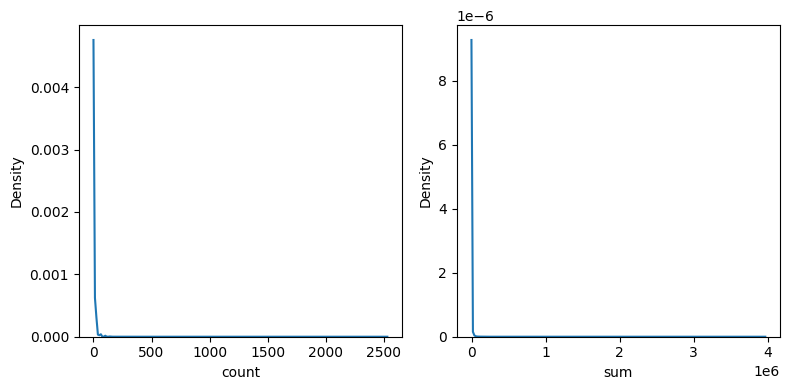

In [25]:
# График распределния значений count и sum

plt.figure(figsize=(8, 4))
for i, name in enumerate(["count", "sum"]):
    ax = plt.subplot(1, 2, i + 1)
    ax = sns.kdeplot(data=pays_df, x=name)
plt.tight_layout()
plt.show()

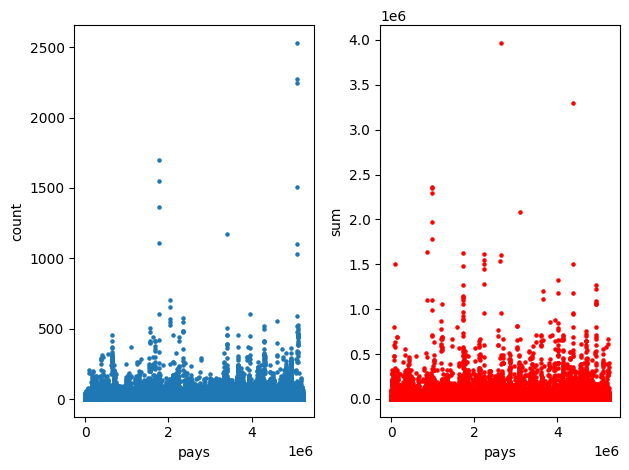

In [26]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(range(len(pays_df["count"])), pays_df["count"], s=5)
axs[0].set_ylabel("count")
axs[0].set_xlabel("pays")

axs[1].scatter(range(len(pays_df["sum"])), pays_df["sum"], s=5, c="r")
axs[1].set_ylabel("sum")
axs[1].set_xlabel("pays")

plt.tight_layout()
plt.show()

Приведенные графики свидетеьльствуют о крайне неравномерном распределении. Несмотря на то, что аномальные значения количества платежей и суммы платежей могут не быть выбросами, а отражать специфическое поведение отдельных фирм, попробуем применить межквартильный размах к этим колонкам.

In [27]:
sum_count = pays_df[["count", "sum"]]
sum_count_q1 = sum_count.quantile(q=0.25)  # первый квартиль
sum_count_q3 = sum_count.quantile(q=0.75)  # третий квартиль
sum_count_iqr = sum_count.apply(iqr)  # межквартильный размах

pays_df_clear = pays_df.loc[
    ~(
        (sum_count < (sum_count_q1 - 1.5 * sum_count_iqr))
        | (sum_count > (sum_count_q3 + 1.5 * sum_count_iqr))
    ).any(axis=1)
]  # отсеиваются строки, в которых не выполняются указанные неравенства по любой из двух колонок

pays_df_clear

,hash_inn_kt,hash_inn_dt,week,count,sum
2,0,0,7,2,79.600
4,0,0,12,2,79.600
6,0,0,16,2,0.920
8,0,0,21,4,0.800
10,0,7212,3,1,134.548
...,...,...,...,...,...
5430143,260510,122389,21,1,48.800
5430144,260511,77935,2,2,79.600
5430147,260511,77935,14,2,7.600
5430148,260511,77935,15,2,79.600


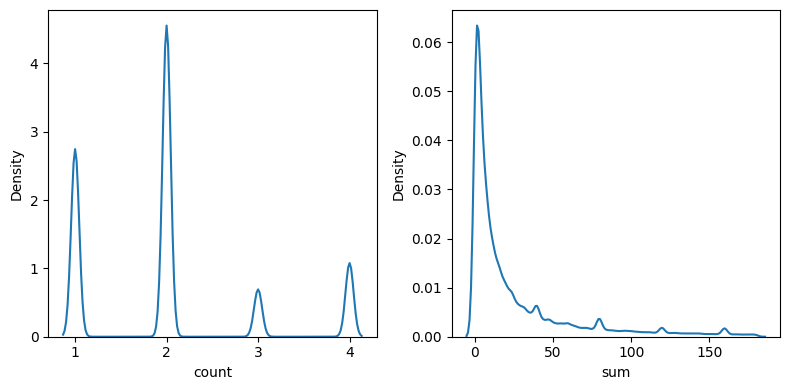

In [28]:
plt.figure(figsize=(8, 4))
for i, name in enumerate(["count", "sum"]):
    ax = plt.subplot(1, 2, i + 1)
    ax = sns.kdeplot(data=pays_df_clear, x=name)
plt.tight_layout()
plt.show()

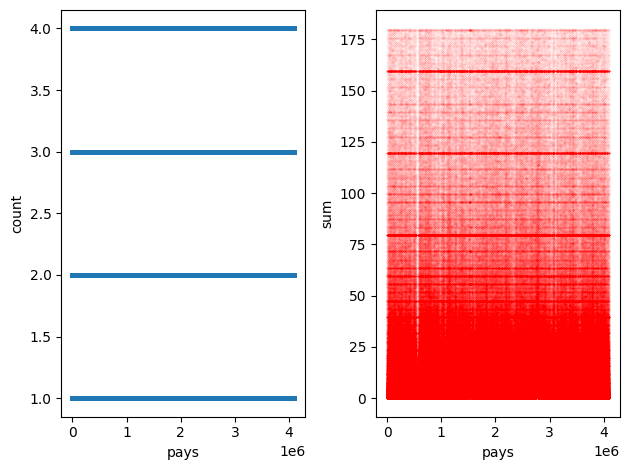

In [29]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(range(len(pays_df_clear["count"])), pays_df_clear["count"], s=5)
axs[0].set_ylabel("count")
axs[0].set_xlabel("pays")

axs[1].scatter(range(len(pays_df_clear["sum"])), pays_df_clear["sum"], s=0.0001, c="r")
axs[1].set_ylabel("sum")
axs[1].set_xlabel("pays")

plt.tight_layout()
plt.show()

In [30]:
# Количество классов (уникальных кодов ОКВЭД) среди фирм, не подлежащих классификации и имеющих информацию о входящих и исходящих платежах
set_inn_with_in_out_pays_clear = (
    set(pays_df_clear["hash_inn_dt"])
    & set(pays_df_clear["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] != -1])
)
(
    inn_info_public_df["okved2"].loc[
        inn_info_public_df["hash_inn"].isin(set_inn_with_in_out_pays_clear)
    ]
).nunique()

80

In [31]:
# Количество фирм, подлежащих классификации, одновременно с информацией об отправленных и о полученных платежах
(
    set(pays_df_clear["hash_inn_dt"])
    & set(pays_df_clear["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] == -1])
).__len__()

30227

In [32]:
# Количество фирм, не подлежащих классификации, одновременно с информацией об отправленных и о полученных платежах
(
    set(pays_df_clear["hash_inn_dt"])
    & set(pays_df_clear["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"].loc[inn_info_public_df["okved2"] != -1])
).__len__()

62003

In [33]:
# Стратификация фирм по классам
(
    inn_info_public_df["okved2"].loc[
        inn_info_public_df["hash_inn"].isin(set_inn_with_in_out_pays_clear)
    ]
).value_counts()

okved2
12    16840
14     4884
34     3857
4      3338
52     2685
      ...  
1        22
2        21
73       17
13       15
66        5
Name: count, Length: 80, dtype: int64

После применения данного метода из `pays_df` было удалено около 1/5 платежей. Как было отмечено выше, возможно, данные пплатежи не являлись выбросами. Однако, после удаления "выбросов" распредедление данных преобрело интерпретируемые формы, как видно из графиков. При этом число фирм с информацией о входящих и исходящих платежах изменилось незначительно, а количество классов осталось неизменным, что может свидетельствовать об отсутствии специфических фирм в удаленных данных.

Качественная оценка изменения стратификации до и после отчистки от выбросов, свидетельствует в пользу того, что выбросы в данных скорее содержались, так как количество сэмплов уменьшилось во всех стратах

### 2. Составление датасета для обучения модели

В качестве объектов в датасете будут выступать фирмы. В качестве признаков у каждого объекта предварительно будут следующие поля:

- обезличенный инн **hash_inn**
- регион **region**
- количество уникальных контрагентов по входящим платежам **uniq_contr_in**
- общее количество входящих платежей **tot_count_in**
- среднее количество входящих платежей за неделю **mean_count_in**
- общая сумма входящих платежей **tot_sum_in**
- средняя сумма входящих платежей за неделю **mean_sum_in**
- количество уникальных контрагентов по исходящим платежам **uniq_contr_out**
- общее количество исходящих платежей **tot_count_out**
- среднее количество исходящих платежей за неделю **mean_count_out**
- общая сумма исходящих платежей **tot_sum_out**
- средняя сумма исходящих платежей за неделю **mean_sum_out**

Целевой переменной является поле **okved2**

In [34]:
# Количество фирм одновременно с информацией об отправленных и о полученных платежах

tot_set_inn_with_in_out_pays_clear = (
    set(pays_df_clear["hash_inn_dt"])
    & set(pays_df_clear["hash_inn_kt"])
    & set(inn_info_public_df["hash_inn"])
)

len(tot_set_inn_with_in_out_pays_clear)

92230

In [35]:
# Соберем информацию о фходящих платежах фирм и об исходящих платежах

pays_df_clear_out = pays_df_clear[["hash_inn_kt", "hash_inn_dt", "count", "sum"]].loc[
    pays_df_clear["hash_inn_kt"].isin(tot_set_inn_with_in_out_pays_clear)
]

pays_df_clear_in = pays_df_clear[["hash_inn_dt", "hash_inn_kt", "count", "sum"]].loc[
    pays_df_clear["hash_inn_dt"].isin(tot_set_inn_with_in_out_pays_clear)
]

In [36]:
pays_df_clear_in["hash_inn_dt"].nunique(), pays_df_clear_out["hash_inn_kt"].nunique()

(92230, 92230)

In [37]:
# Подсчет значений признаков для каждой фирмы

inn_pays_df_clear_in = (
    pays_df_clear_in.groupby("hash_inn_dt")
    .agg(
        uniq_contr_in=pd.NamedAgg(column="hash_inn_kt", aggfunc="nunique"),
        tot_count_in=pd.NamedAgg(column="count", aggfunc="sum"),
        mean_count_in=pd.NamedAgg(column="count", aggfunc="mean"),
        tot_sum_in=pd.NamedAgg(column="sum", aggfunc="sum"),
        mean_sum_in=pd.NamedAgg(column="sum", aggfunc="mean"),
    )
    .reset_index()
)

inn_pays_df_clear_out = (
    pays_df_clear_out.groupby("hash_inn_kt")
    .agg(
        uniq_contr_out=pd.NamedAgg(column="hash_inn_dt", aggfunc="nunique"),
        tot_count_out=pd.NamedAgg(column="count", aggfunc="sum"),
        mean_count_out=pd.NamedAgg(column="count", aggfunc="mean"),
        tot_sum_out=pd.NamedAgg(column="sum", aggfunc="sum"),
        mean_sum_out=pd.NamedAgg(column="sum", aggfunc="mean"),
    )
    .reset_index()
)

In [38]:
inn_pays_df_clear_in

,hash_inn_dt,uniq_contr_in,tot_count_in,mean_count_in,tot_sum_in,mean_sum_in
0,0,124,629,1.839181,9571.260,27.986140
1,2,1,18,2.250000,293.212,36.651500
2,5,4,28,2.000000,123.400,8.814286
3,7,5,8,1.142857,371.348,53.049714
4,10,9,60,2.142857,134.216,4.793429
...,...,...,...,...,...,...
92225,260504,16,76,1.727273,491.532,11.171182
92226,260507,1,6,3.000000,271.836,135.918000
92227,260509,18,131,2.425926,1064.088,19.705333
92228,260510,1,2,2.000000,2.196,2.196000


In [39]:
inn_pays_df_clear_out

,hash_inn_kt,uniq_contr_out,tot_count_out,mean_count_out,tot_sum_out,mean_sum_out
0,0,19,57,1.900000,1613.672,53.789067
1,2,3,5,1.666667,36.240,12.080000
2,5,3,40,1.904762,272.288,12.966095
3,7,2,17,1.062500,603.376,37.711000
4,10,1,4,2.000000,1.600,0.800000
...,...,...,...,...,...,...
92225,260504,11,40,2.500000,980.276,61.267250
92226,260507,1,9,1.500000,139.016,23.169333
92227,260509,21,261,2.088000,5522.060,44.176480
92228,260510,1,3,1.000000,220.760,73.586667


In [40]:
inn_info_in_out_df = (
    inn_info_public_df[["hash_inn", "region", "okved2"]]
    .sort_values("hash_inn")
    .loc[inn_info_public_df["hash_inn"].isin(tot_set_inn_with_in_out_pays_clear)]
).reset_index(drop=True)

In [41]:
inn_info_in_out_df

,hash_inn,region,okved2
0,0,84,-1
1,2,58,-1
2,5,85,14
3,7,18,12
4,10,85,14
...,...,...,...
92225,260504,85,12
92226,260507,64,69
92227,260509,84,12
92228,260510,58,43


In [83]:
# Соединим получившиеся таблицы

dataset_df = pd.concat(
    [inn_info_in_out_df, inn_pays_df_clear_in, inn_pays_df_clear_out], axis=1
).drop(["hash_inn_kt", "hash_inn_dt"], axis=1)

dataset_df

,hash_inn,region,okved2,uniq_contr_in,tot_count_in,mean_count_in,tot_sum_in,mean_sum_in,uniq_contr_out,tot_count_out,mean_count_out,tot_sum_out,mean_sum_out
0,0,84,-1,124,629,1.839181,9571.260,27.986140,19,57,1.900000,1613.672,53.789067
1,2,58,-1,1,18,2.250000,293.212,36.651500,3,5,1.666667,36.240,12.080000
2,5,85,14,4,28,2.000000,123.400,8.814286,3,40,1.904762,272.288,12.966095
3,7,18,12,5,8,1.142857,371.348,53.049714,2,17,1.062500,603.376,37.711000
4,10,85,14,9,60,2.142857,134.216,4.793429,1,4,2.000000,1.600,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92225,260504,85,12,16,76,1.727273,491.532,11.171182,11,40,2.500000,980.276,61.267250
92226,260507,64,69,1,6,3.000000,271.836,135.918000,1,9,1.500000,139.016,23.169333
92227,260509,84,12,18,131,2.425926,1064.088,19.705333,21,261,2.088000,5522.060,44.176480
92228,260510,58,43,1,2,2.000000,2.196,2.196000,1,3,1.000000,220.760,73.586667


[]

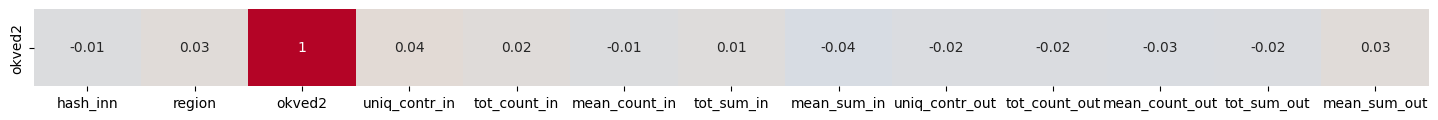

In [43]:
corr = dataset_df.loc[dataset_df["okved2"] != -1].corr().round(2)
plt.figure(figsize=(18, 1))
sns.heatmap(
    data=corr.loc[corr.index == "okved2", :],
    cmap="coolwarm",
    annot=True,
    vmin=-1,
    vmax=1,
    square=False,
    cbar=False,
)
plt.plot()

Коэффициент корелляции для целевой переменной на данном датасете не показывает значимых взаимосвязей. Следовательно, если между признаками и целевой переменной есть какая-то взаимосвязь, то она носит нелинейный характер.

In [84]:
# Разделение датасета на фирмы с известным ОКВЭД и неизвестным

train_test_df = dataset_df.loc[dataset_df["okved2"] != -1]
for_predict_df = dataset_df.loc[dataset_df["okved2"] == -1].drop(columns=["okved2"])

In [85]:
train_test_df

,hash_inn,region,okved2,uniq_contr_in,tot_count_in,mean_count_in,tot_sum_in,mean_sum_in,uniq_contr_out,tot_count_out,mean_count_out,tot_sum_out,mean_sum_out
2,5,85,14,4,28,2.000000,123.400,8.814286,3,40,1.904762,272.288,12.966095
3,7,18,12,5,8,1.142857,371.348,53.049714,2,17,1.062500,603.376,37.711000
4,10,85,14,9,60,2.142857,134.216,4.793429,1,4,2.000000,1.600,0.800000
5,17,82,53,104,819,2.127273,4988.892,12.958161,35,71,1.731707,770.920,18.802927
6,18,60,14,1,1,1.000000,136.752,136.752000,1,5,1.000000,683.760,136.752000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92225,260504,85,12,16,76,1.727273,491.532,11.171182,11,40,2.500000,980.276,61.267250
92226,260507,64,69,1,6,3.000000,271.836,135.918000,1,9,1.500000,139.016,23.169333
92227,260509,84,12,18,131,2.425926,1064.088,19.705333,21,261,2.088000,5522.060,44.176480
92228,260510,58,43,1,2,2.000000,2.196,2.196000,1,3,1.000000,220.760,73.586667


In [86]:
for_predict_df

,hash_inn,region,uniq_contr_in,tot_count_in,mean_count_in,tot_sum_in,mean_sum_in,uniq_contr_out,tot_count_out,mean_count_out,tot_sum_out,mean_sum_out
0,0,84,124,629,1.839181,9571.260,27.986140,19,57,1.900000,1613.672,53.789067
1,2,58,1,18,2.250000,293.212,36.651500,3,5,1.666667,36.240,12.080000
7,19,60,1,1,1.000000,1.164,1.164000,28,197,1.950495,433.580,4.292871
15,43,84,74,291,1.419512,1757.748,8.574380,13,78,1.695652,932.432,20.270261
21,60,80,3,18,2.250000,75.744,9.468000,1,1,1.000000,1.600,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
92211,260474,60,1,2,1.000000,260.024,130.012000,2,6,2.000000,120.460,40.153333
92212,260475,73,3,34,2.000000,199.484,11.734353,6,71,1.577778,1367.732,30.394044
92213,260476,80,5,12,2.000000,210.836,35.139333,1,2,2.000000,48.904,48.904000
92214,260483,84,4,10,1.428571,173.744,24.820571,6,18,1.200000,680.400,45.360000


### 3. Предобработка данных, выбор и обучение модели

In [47]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from pandas import DataFrame
from numpy.typing import ArrayLike

RANDOM_STATE = 42

In [87]:
# Определим класс для удобного препроцессинга во время обучения и прогноза


class Preprocessor:
    def preprocess_for_train(
        self,
        data: DataFrame,
        reduce: bool = True,
        sigm: float = 0.8,
        test_size: float = 0.2,
    ) -> list[ArrayLike]:

        self.reduce = reduce

        numeric_features = [
            "uniq_contr_in",
            "tot_count_in",
            "mean_count_in",
            "tot_sum_in",
            "mean_sum_in",
            "uniq_contr_out",
            "tot_count_out",
            "mean_count_out",
            "tot_sum_out",
            "mean_sum_out",
        ]

        categorical_features = ["region"]
        data = data.drop(columns=["hash_inn"])

        ohe = OneHotEncoder(handle_unknown="ignore")
        std = StandardScaler()
        self.column_transformer = ColumnTransformer(
            transformers=[
                ("num", std, numeric_features),
                ("cat", ohe, categorical_features),
            ]
        )

        X = data.drop(columns=["okved2"])
        Y = data["okved2"]

        X_train, X_test, Y_train, Y_test = train_test_split(
            X,
            Y,
            test_size=test_size,
            shuffle=True,
            random_state=RANDOM_STATE,
            stratify=Y,
        )

        X_train = self.column_transformer.fit_transform(X_train)
        X_test = self.column_transformer.transform(X_test)

        if self.reduce:
            X_train = self.reduce_dim(X_train, sigm=sigm)
            X_test = self.opt_reducer.transform(X_test)

        return X_train, X_test, Y_train.to_numpy(), Y_test.to_numpy()

    def preprocess_for_predict(self, data: DataFrame) -> ArrayLike:
        data = data.drop(columns=["hash_inn"])
        X = self.column_transformer.transform(data)

        if self.reduce:
            X = self.opt_reducer.transform(X)

        return X

    def reduce_dim(self, X, sigm: float = 0.8) -> ArrayLike:
        reducer = TruncatedSVD(n_components=X.shape[1], random_state=RANDOM_STATE)
        reducer.fit(X)
        opt_n_pc = np.count_nonzero(np.cumsum(reducer.explained_variance_ratio_) < sigm)
        self.opt_reducer = TruncatedSVD(opt_n_pc, random_state=RANDOM_STATE)

        return self.opt_reducer.fit_transform(X)

In [88]:
# Инициализируем экземпляр препроцессора и разделим выборку на обучающую и тестовую.
# В дальнейшем на этапе прогнозирования этот экземпляр класса можно будет использовать для единообразного преобразования входных данных

preproc = Preprocessor()

X_train, X_test, Y_train, Y_test = preproc.preprocess_for_train(
    train_test_df, sigm=0.95
)

In [89]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((49602, 11), (12401, 11), (49602,), (12401,))

In [51]:
# Предварительный выбор алгоритма обучения проведем с настройками по умолчанию на кроссвалидации из 4 алгоритмов:
# градиентный бустинг, решающее дерево, метод опорных векторов с ядерным трюком и многослойный перцептрон

# В качестве метрики в данной ситуации подойдет accuracy, потому что нет необходимости балансировать модель между полнотой и точностью

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

gbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
svc = SVC(random_state=RANDOM_STATE)
mlp = MLPClassifier(random_state=RANDOM_STATE)

In [52]:
cv_gbc = cross_val_score(gbc, X_train, Y_train, scoring="accuracy", cv=kf, n_jobs=-1)

In [53]:
cv_dtc = cross_val_score(dtc, X_train, Y_train, scoring="accuracy", cv=kf, n_jobs=-1)

In [54]:
cv_svc = cross_val_score(svc, X_train, Y_train, scoring="accuracy", cv=kf, n_jobs=-1)

In [55]:
cv_mlp = cross_val_score(mlp, X_train, Y_train, scoring="accuracy", cv=kf, n_jobs=-1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

In [56]:
cv_gbc.mean(), cv_dtc.mean(), cv_svc.mean(), cv_mlp.mean()

(0.2385590294487177,
 0.13384539260621542,
 0.29016975900746816,
 0.304665144720379)

Прежде, чем выбрать модель для дальнейшей оптимизации следует проверить как повлияет на accuracy моделей балансировка классов

In [57]:
# Распределение образцов по классам до семплирования

np.sort(np.bincount(Y_train))

array([    4,    12,    14,    17,    18,    19,    20,    30,    34,
          36,    42,    50,    58,    63,    63,    65,    66,    67,
          70,    71,    73,    77,    97,   115,   118,   139,   142,
         148,   156,   158,   164,   166,   186,   189,   194,   204,
         213,   217,   226,   241,   246,   254,   259,   280,   292,
         297,   302,   310,   324,   340,   348,   358,   372,   383,
         390,   396,   468,   471,   510,   518,   566,   615,   622,
         625,   628,   683,   686,   758,   843,   893,   941,  1003,
        1174,  1352,  1770,  2148,  2670,  3086,  3907, 13472])

In [58]:
# Для балансировки классов одновременно применим under_sampling для мажоритарных классов и over_sampling для миноритарных классов

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

maj_list = np.where(np.bincount(Y_train) > 10000)[0].tolist()
min_list = np.where(np.bincount(Y_train) < 1000)[0].tolist()

undersamp = EditedNearestNeighbours(sampling_strategy=maj_list, n_neighbors=3, kind_sel='mode', n_jobs=-1)
oversamp = SMOTE(sampling_strategy={k: 1100 for k in min_list}, k_neighbors=3, n_jobs=-1, random_state=RANDOM_STATE)
X_resamp, Y_resamp = undersamp.fit_resample(X_train, Y_train)
X_resamp, Y_resamp = oversamp.fit_resample(X_resamp, Y_resamp)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [59]:
# Распределение образцов по классам после семплирования

np.sort(np.bincount(Y_resamp))

array([1003, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1174, 1352, 1770, 2148, 2670,
       3086, 3907, 6859])

In [60]:
# Общее число образцов

Y_resamp.shape[0]

102069

In [61]:
# Оценим метрику на сбалансированном наборе

In [62]:
cv_gbc = cross_val_score(gbc, X_resamp, Y_resamp, scoring="accuracy", cv=kf, n_jobs=-1)

In [63]:
cv_dtc = cross_val_score(dtc, X_resamp, Y_resamp, scoring="accuracy", cv=kf, n_jobs=-1)

In [64]:
cv_svc = cross_val_score(svc, X_resamp, Y_resamp, scoring="accuracy", cv=kf, n_jobs=-1)

In [65]:
cv_mlp = cross_val_score(mlp, X_resamp, Y_resamp, scoring="accuracy", cv=kf, n_jobs=-1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

In [66]:
cv_gbc.mean(), cv_dtc.mean(), cv_svc.mean(), cv_mlp.mean()

(0.38447524558844626,
 0.4407116597246104,
 0.17949623941633475,
 0.25356376969632066)

In [67]:
from sklearn.metrics import accuracy_score

gbc.fit(X_resamp, Y_resamp)
dtc.fit(X_resamp, Y_resamp)

DecisionTreeClassifier(random_state=42)

In [68]:
accuracy_score(Y_test, gbc.predict(X_test)), accuracy_score(Y_test, dtc.predict(X_test))

(0.13571486170470123, 0.09015401983710991)

На первый взгляд кажется, что балансировка классов помогает улучшит качество некоторых моделей. Однако, при проверке на отложенной выборке видно, что балансировка (по крайней мере в данном виде) не сохраняет паттерны исходного набора. При этом для моделей MLP и SVM качество на кросвалидации пдает, по сравнению с несбалансирвоанным датасетом

В базовой конфигурации лучшее качество на кроссвалидации показал перцептрон. Возьмем эту модель для дальнейшей оптимизации. Выборку оставим несбалансированной

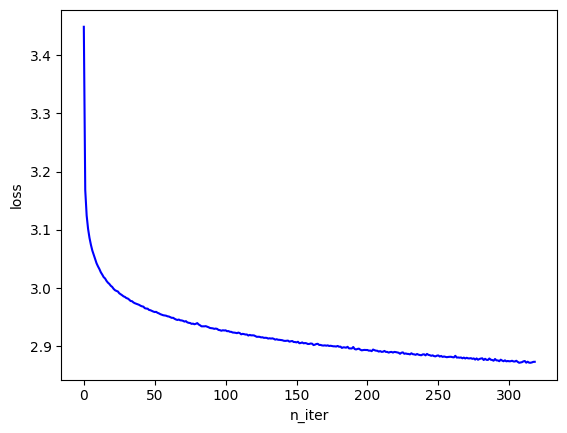

In [69]:
# Построим график оптимизации перцептрона

mlp = MLPClassifier(max_iter=500, shuffle=True, random_state=RANDOM_STATE)

mlp.fit(X_train, Y_train)

plt.plot(range(mlp.n_iter_), mlp.loss_curve_, c='b')
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.show()

In [70]:
mlp = MLPClassifier(random_state=RANDOM_STATE, early_stopping=True, shuffle=True)
mlp.fit(X_train, Y_train)
mlp.n_iter_

97

При стандартной настройке алгоритма оптимизации сходимость наступает примерно после 300 итераций. Однако, качество на валидации перестает значимо меняться уже после 97 итераций.

In [71]:
# Качество модели без мажоритарного класса
cross_val_score(
    mlp, X_train[Y_train != 12], Y_train[Y_train != 12], cv=kf, n_jobs=-1
).mean()

0.16717392246537816

In [72]:
# Попробуем улучшить качество модели, подобрав параметры с помощью решетчатого поиска

param_grid = {
    "hidden_layer_sizes": [(200), (300), (100, 100)],
    "activation": ["logistic", "tanh"],
    "batch_size": [100, 200],
}

gs = GridSearchCV(
    mlp,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=kf,
    return_train_score=True,
    verbose=1
)

In [73]:
gs.fit(X_train, Y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh'],
                         'batch_size': [100, 200],
                         'hidden_layer_sizes': [200, 300, (100, 100)]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [74]:
res_df = pd.DataFrame(gs.cv_results_)
score_df = res_df[["params", "mean_train_score", "mean_test_score"]].assign(
    delta = res_df["mean_train_score"] - res_df["mean_train_score"]
)
pd.set_option('max_colwidth', 120)
score_df.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,delta
11,"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': (100, 100)}",0.309161,0.305512,0.0
8,"{'activation': 'tanh', 'batch_size': 100, 'hidden_layer_sizes': (100, 100)}",0.310061,0.305089,0.0
2,"{'activation': 'logistic', 'batch_size': 100, 'hidden_layer_sizes': (100, 100)}",0.304477,0.302024,0.0
0,"{'activation': 'logistic', 'batch_size': 100, 'hidden_layer_sizes': 200}",0.302145,0.300351,0.0
9,"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 200}",0.302515,0.300351,0.0
6,"{'activation': 'tanh', 'batch_size': 100, 'hidden_layer_sizes': 200}",0.302589,0.299786,0.0
5,"{'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': (100, 100)}",0.300915,0.299665,0.0
1,"{'activation': 'logistic', 'batch_size': 100, 'hidden_layer_sizes': 300}",0.301540,0.299484,0.0
10,"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 300}",0.302071,0.298718,0.0
7,"{'activation': 'tanh', 'batch_size': 100, 'hidden_layer_sizes': 300}",0.301352,0.298516,0.0


Изменения гиперпараметров модели не оказывают какого-либо знаичмого влияния на качсетво модели. Помимо опробованных здесь моделей, были также опробованы множество других алгоритмов МО разных типов с разными опитмизаторами. Все они упираются в показатель accuracy 0.3. Такое качество лучше случайного угадывания, но почти не отличается от константного алгоритма (назначение метки мажоритарного класса). Очевидно, такое поведение может быть связано с сильным дисбалансом классов или застреванием алгоритмов оптимизации в локальных минимумах. При этом ни исключение мажоритарного класса, ни усложнение алгоритмов не уменьшают степень недообученности моделей

In [75]:
# Обучение конечной модели и проверка качества на отложенной выборке

opt_params = score_df['params'][11]
opt_mlp = MLPClassifier(**opt_params, random_state=RANDOM_STATE, early_stopping=True, shuffle=True)
opt_mlp.fit(X_train, Y_train)

accuracy_score(Y_test, opt_mlp.predict(X_test))

0.30586243044915734

In [90]:
# Предсказание неизвестных кодов ОКВЭД

X_pred = preproc.preprocess_for_predict(for_predict_df)
Y_pred = opt_mlp.predict(X_pred)

pred_df = pd.DataFrame({'hash_inn':for_predict_df['hash_inn'], 'y': Y_pred})
pred_df

,hash_inn,y
0,0,52
1,2,12
7,19,12
15,43,22
21,60,14
...,...,...
92211,260474,12
92212,260475,12
92213,260476,12
92214,260483,12


In [91]:
# сохранение результатов в файл

pred_df.to_csv('DmitriyAtamanov-25032024-SberIndustry.csv', sep=',', index=False)